## CCNSS 2018 module 2
# Tutorial 3 - Psychophysics and probabilistic modelling



*Please execute the cells bellow to initialize the notebook environment*

In [0]:
!if [ ! -d data ]; then git clone https://github.com/ccnss/ccnss2018_students; \
                        cp -rf ccnss2018_students/module2/3_psychophysics_and_probabilistic_modelling/data ./; fi

In [0]:
import matplotlib.pyplot as plt      # import matplotlib
import numpy as np                   # import numpy
import scipy as sp                   # import scipy
from scipy import optimize, stats
import pandas as pd                  # import pandas
import random                        # import basic random number generator functions
import time                          # import time function to time minimize
import os

try:
    import ipywidgets as widgets
except:
    get_ipython().system('pip install ipywidgets')
    import ipywidgets as widgets

data_folder = 'data'

fig_w, fig_h = (6, 4)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
plt.style.use('ggplot')

## Objectives

In this notebook we'll clean-up data from a 2-Alternative Forced Choice task and plot psychometric functions. 

We will also analyse behavioural data from a task that measure participant innate prior, and implement a Conjugate Beta-Bernoulli model that performs the task optimally (ideal-observer) and can recover the participants priors from their behaviour.

## Background

Psychophysics quantitatively investigates the relationship between physical stimuli and the sensations and perceptions they produce. It is a general class of methods that can be applied to study a perceptual system. Modern applications rely heavily on threshold measurement, ideal observer analysis, and signal detection theory.

In psychophysics, experiments seek to determine whether the subject can detect a stimulus, identify it, differentiate between it and another stimulus, or describe the magnitude or nature of this difference.

A psychometric function is an inferential model applied in detection and discrimination tasks. It models the relationship between a given feature of a physical stimulus, (e.g. velocity, duration, brightness, weight etc.), and forced-choice responses of a human test subject. The psychometric function therefore is a specific application of the generalized linear model (GLM) to psychophysical data. The probability of response is related to a linear combination of predictors by means of a sigmoid link function (e.g. probit, logit, etc.).

We analyze data from a two-alternative forced choice task (e.g. the random-dot-task). In these tasks ambiguous evidence for two alternative choices is presented to an observer. The ambiguity results in imperfect performance, that varies with the strength of the ambiguity. This relationship is quantified by the *psychometric function*.

**EXERCISE 1**

Loading the data

**Instructions**

* Read the data from file `dots_psychophysics.txt`
* Each line is one trial, the columnns encode
    - coherence of random dot pattern
    - direction of random dot pattern
    - the direction the monkey chose
    - if the monkey was rewarded
    - the monkey's reaction time
* The direction / choice is encoded as: 1 = 0% coherence, 2 = left stimuli, 3 = right stimuli
* On 0% coherence trials the monkey was rewarded randomly
* Replace numbers '2' and '3' by 'left' and 'right' respectively, and rewarded '1' and '0' into booleans

   Hint: look up the function `df.replace()` from Pandas
  
* Print the first 5 rows of the data

   Hint: look up function `df.head()` from Pandas

In [0]:
data_file = os.path.join(data_folder, 'dots_psychophysics.txt')

#insert code here

dotsData = pd.read_csv(data_file, 
                       delimiter=' ', skipinitialspace=True, index_col=None, header=None, 
                       names=['coherence', 'direction', 'choice', 'rewarded', 'rt'])

dotsData.replace({'direction': {1.: '0%', 2.: 'left', 3.: 'right'},
                  'choice': {1.: '0%', 2.: 'left', 3.: 'right'},
                 }, inplace=True)

dotsData['rewarded'] = dotsData['rewarded'].astype(np.bool)

dotsData.head()

**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/3_psychophysics_and_probabilistic_modelling/figures/expected_ex1.png)

**EXERCISE 2**

Checking the data

**Instructions**

* Check that whenever coherence is 0, direction also encodes the 0% stimulus, and print `True` or `False`
* Plot the distribution of choices when coherence == 0
* Check that for non-zero-coherence trials (whenever `direction == choice` then `rewarded == True`) and print `True` or `False` accordingly

- Check 1 (coherence 0 -> 0% stim): [ True]
- Check 2 (direction == choice -> rewarded?): [ True]


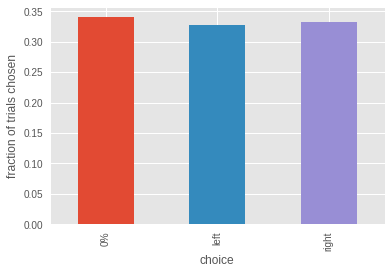

In [0]:
#insert code here

check1 = dotsData[dotsData['coherence'] == 0.] \
        ['direction'] \
        .unique() \
        == '0%'
        
coherentTrials = dotsData[dotsData['coherence'] != 0.] 
check2 = coherentTrials[coherentTrials['direction'] == coherentTrials['choice']] \
        ['rewarded'] \
        .unique()

print('- Check 1 (coherence 0 -> 0% stim): ' + str(check1))
print('- Check 2 (direction == choice -> rewarded?): ' + str(check1))

nChoicesAt0Coherence = dotsData[dotsData['coherence'] == 0.] \
                                .groupby('choice') \
                                .count() \
                                ['coherence'] # all columns contain the same information

# normalize to proportions
fracChoisesAt0Coherence = nChoicesAt0Coherence / nChoicesAt0Coherence.sum()

plt.figure()
fracChoisesAt0Coherence.plot(kind='bar')
plt.ylabel('fraction of trials chosen')
plt.show()

**EXPECTED OUTPUT**
```
- Check 1 (coherence 0 -> 0% stim): [ True]
- Check 2 (direction == choice -> rewarded?): [ True]
```

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/3_psychophysics_and_probabilistic_modelling/figures/expected_ex2.png)

**EXERCISE 3**

Checking the data

**Instructions**

* Using a bar plot, plot of the number of trials, broken down by stimulus direction and coherence. 

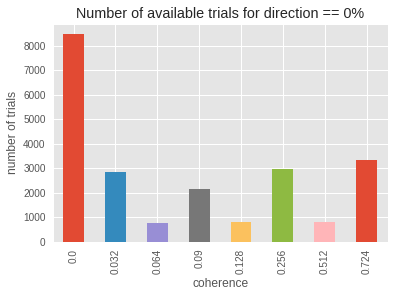

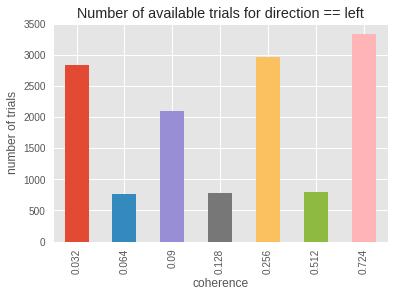

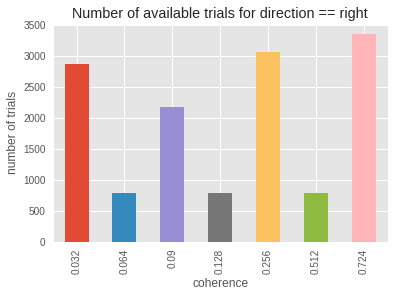

In [0]:
#insert code here

for direction, directionData in dotsData.groupby('direction'):
    plt.figure()
    plt.title('Number of available trials for direction == %s' % direction)
    directionData.groupby('coherence')['coherence'] \
                    .count() \
                    .plot(kind='bar')
    plt.ylabel('number of trials')
    plt.show()

**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/3_psychophysics_and_probabilistic_modelling/figures/expected_ex3.png)

** EXERCISE 4: Psychometric function **

A psychometric function is an inferential model applied in detection and discrimination tasks. It models the relationship between a given feature of a physical stimulus, (e.g. velocity, duration, brightness, weight etc.), and forced-choice responses of a human test subject. The psychometric function therefore is a specific application of the generalized linear model (GLM) to psychophysical data. The probability of response is related to a linear combination of predictors by means of a sigmoid link function (e.g. probit, logit, etc.).

** Insructions **

* Remove aborted trials, i.e. trials in which the monkey chose the stimulus direction but wasn't rewarded
* Plot the psychometric function, i.e. fraction of correct choices vs. coherence  (i.e. plot fraction of right choices for all coherence levels, where for left choices coherence is set to negative values)

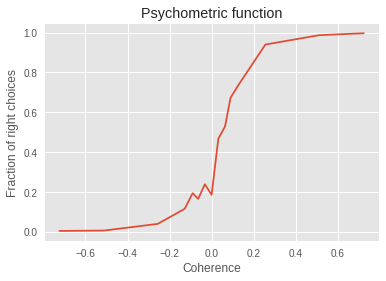

In [0]:
#insert code here

cond_aborted = (dotsData['coherence'] > 0) & \
         (dotsData['direction'] == dotsData['choice']) & \
         (dotsData['rewarded'] == False)

dotsData = dotsData[~cond_aborted]

zeroPsychometricFunction = pd.Series((dotsData[dotsData['direction'] == '0%']['choice'] == 'right').mean(), index=[0.])
    
rightPsychometricFunction = dotsData[dotsData['direction'] == 'right'] \
                            .groupby('coherence') \
                            .apply(lambda df: (df['choice'] == 'right').mean())
        
leftPsychometricFunction = dotsData[dotsData['direction'] == 'left'] \
                            .groupby('coherence') \
                            .apply(lambda df: (df['choice'] == 'right').mean())

# flip sign of coherence (which is the index) for leftPsychometricFunction to combine left and right afterwards
leftPsychometricFunction.index *= -1

# combine the three psychometric functions in one Series
psychometricFunction = pd.concat([leftPsychometricFunction, zeroPsychometricFunction, rightPsychometricFunction]) \
                            .sort_index()

plt.figure()
psychometricFunction.plot()
plt.xlabel('Coherence')
plt.ylabel('Fraction of right choices')
plt.title('Psychometric function')
plt.show()

**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/3_psychophysics_and_probabilistic_modelling/figures/expected_ex4.png)

# Probabilistic modelling

## Background : Optimism Task

Optimists hold positive a priori beliefs about the future. In Bayesian statistical theory, a priori beliefs can be overcome by experience. However, optimistic beliefs can at times appear surprisingly resistant to evidence, suggesting that optimism might also influence how new information is selected and learned. 

Here, we will model how inate optimistic biases influence behaviour in a Pavlovian conditioning task. That is, how participants prior beliefs about *'How likely is something good to happen'* will change their behaviour in a pavlovian instrumental task. 

*** Task ***

The experiment contained two types of screens (See figure below): 
    1 - a series of observation screens which subjects have to passively observe. On each of these screens a fractal stimulus was shown to be associated with a binary reward (the presentation of the fractal was followed after 700 ms by the presentation of a full treasure chest) or not (the fractal led to an empty treasure chest); 
    2 - Participants were then asked to choose between a fractal stimulus (that was observed a couple of times paired with treasures or not),  and a blue square with known probability of winning. In this decision phase, the subjects were told to maximize reward gains.

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/3_psychophysics_and_probabilistic_modelling/figures/Optimism_task.png)

In the example above, the subject sees the yellow fractal twice. Once associated with a reward (full treasure chest), and once without a reward (empty treasure chest). That is, the expected value of the yellow fractal is 0.5 (i.e.: 1 reward + 0 reward / 2 presentations). The participant then arrives to a decision screen (D1), where he/she needs to make a 2-Alternative Force Choice (2-AFC) between the yellow fractal , or the blue target. 

The probability of the blue target to result in a reward (expected value), is 0.6, denoted by the number of black dots out of 10 (i.e. 6 black dots out of 10). In this particular example, the participant should choose the blue target if he/she wants to maximize the chance of getting a reward on that trial. This is because the expected value of the yellow fractal is 0.5, while the known expected value of the target is 0.6. This means that the target has a higher probability of leading to a rewards than the fractal.

Participants see 60 different fractals, seeing each fractal from 3 and up to 8 times each. Since participants cannot accurately count and remember the number of times each fractal was presented with a reward, they must rely on heuristics and/or an appoximation and/or 'gut-feeling' about the *'goodness of a fractal'* based on previous experience with that fractal. This is where we believe the participants' *'optimism bias'* will come into play and shift their decisions.

**Refs**

* [Optimism as a prior belief about the probability of future reward.](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003605) Stankevicius A, Huys QJ, Kalra A, Seriès P., PLoS computational biology. 2014 May 22;10(5):e1003605.

**EXERCISE 5**

Loading the data

**Instructions**

* Read the data from file `Optimism_data.csv` or `Optimism_data.txt`
* Each line is one decision trial, the columnns encode
    - Column 1: the subject number
    - Column 2: the number of times a fractal was rewarded
    - Column 3: the number of times a fractal was presented
    - Column 4: (ignore for now) 
    - Column 5: the target probability of reward
    - Column 6: Whether participant chose the fractal (1) or target (2)
    - ignore other columns
* The decision / choice is encoded as: 1 = chooses fractal stimulus, 2 = chooses target stimulus
* Replace numbers '1' and '2' by 1 and 0 respectively

   Hint: look up function `df.replace()` from Pandas

* Print the first 5 rows of the data

   Hint: look up function `df.head()` from Pandas

In [0]:
#insert code here

data_file = os.path.join(data_folder, 'optimism_data.csv')

df = pd.read_csv(data_file, delimiter=',')

df.replace({'choice': {1.: '1', 2.: '0'},
                 }, inplace=True)

df['choice'] = df['choice'].astype(np.float)

df.head()

**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/3_psychophysics_and_probabilistic_modelling/figures/expected_ex5.png)

**EXERCISE 6**

Calculate and plot the probability of accepting 'target' as a function of the difference between the true expected value of the fractal and that of the target.

We provide skeletton code using 'Pandas' to extract the probability of accepting 'target' for different bins. But this can also be done manually using numpy arrays, or using histogram functions (e.g. `plt.hist()` or `np.hist()`), which returns the counts for different specficied bins. You can choose to solve this exercise with the tools you find most convenient.

**Instructions**

* For each trial, calculate the difference between the expected reward of fractal and target 
* Bin the difference values into bins of fractal-target with the following range : `freq_bins=[-1.01, -0.5, 0, 0.5, 1.01]`
* Calculate the mean acceptance rate per bin and plot it for subject 24.
* Fit a sigmoidal response curve to the participant data and plot it

   Hint: use the sigmoid function below, you may want to use the function `sp.optimize.curve_fit()`

In [0]:
def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y
  
# insert your code below

# Create column 'diff_frac2targ' which computes difference in expected value between fractal and target
df['diff_frac2targ']=

# Define the bins for plotting psychometric curve
freq_bins= 

#Create a 'binned' column and bin each trial as belonging to either bin defined in freq_bins using pd.cut( , )
df['binned']= 

#Select data for subject 24 only, using df.loc[]
df1 = 

#Groupby data for subject 24 using 'binned'
choice_groupby_binned = 
choice_groupby_binned.describe()

#Print p(choose fractal) as function of difference in value between fractal & target (you may want to use choice_groupby_binned.mean())

#Print sigmoid fit to the data


plt.show()

**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/3_psychophysics_and_probabilistic_modelling/figures/expected_ex6.png)

** EXERCISE 7**

Calculate and plot the psychometric function for all participants 1 to 50

**Instructions**

* Loop over participants, and process their data sequentially
    * Use your previous function which calculates the psychometric curve for a given participant data.
    * Plot the participant psychometric curve with keyword `alpha=0.1`
* Note how subjects can have different psychometric function that are shifted either left or right; What do you think this means?

   Hint: think of it in terms of a bias -- optimism/pessimism

In [0]:
# insert your code here


plt.figure()
plt.ylabel('Probability of choosing `fractal`')
plt.xlabel('Binned: Difference in reward probability (Fractal-Target)')
plt.title('Psychometric function for all subjects')

#Select data for subject 1 only
for i in range(len(df['subject_id'].unique())):
  # process & plot data one subject at a time

**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/3_psychophysics_and_probabilistic_modelling/figures/expected_ex7.png)

## Background : Probabilistic model

We will now simulate an optimal observer model for this task.

To do so we will use a Beta-Binomial model, with a softmax link function to add some noise in the responses. 

The probability density for a Binomial distribution is defined as:

\begin{align*} Binom\left(N_i,n_i\right) = \binom{N_i}{n_i} \cdot c_{i}^{n_{i}} (1-c_{i})^{N_{i}-n_{i}}  \end{align*}

where, $n$ is the number of times a fractal was rewarded, and $N$ is the number of times it was presented, $c$ is the probability of being rewarded for that fractal. The maximum likelihood estimates of $c$ can be calculated analytically and correspond to:

\begin{align*} P\left(c_i\mid n_i, N_i\right) = \frac{n_i}{N_i}\end{align*}

---

The standard $Beta$ distribution gives the probability density of a value $x$ on the interval (0,1):

\begin{align*} Beta\left(\alpha,\beta\right) = \frac{x^{\alpha-1}(1-x)^{\beta-1}} {B(\alpha,\beta)}
\end{align*}

where , $\beta$ is the Beta function. As you can see the numerator of the $Beta$ distribution has the same functional form as the Binomial distribution. 

This is because they come from the same family of probability distributions. This means that the $Beta$ prior is a 'conjugate prior' for the Binomial likelihood. We know the analytical form of the posterior distribution for a BetaBinomial conjugate model, such that the posterior is another Beta distribution. As a result we can simplify our model to taking the expectation (mean) of the posterior (a Beta distribution). That is:

\begin{align*} \hat{C_i}=\frac{n_i+\alpha}{N_i+\alpha+\beta}\end{align*}
    
The Softmax link function is defined as:
    
\begin{align*} P(action=fractal)= \frac{e^{\left(\hat{C_i}/ \tau\right)}}{e^{\left(\hat{C_i} / \tau \right)} + e^{\left({C_{target}}/ \tau \right)}} \end{align*}

where $\tau$ is a temperature parameter that controls stochasticity (the higher $\tau$ the more random the behaviour, the lower $\tau$, the more deterministic the behaviour is).

**EXERCISE 8**

Let's implement the Softmax function 

**Instructions**

* Implement the Softmax function described above that takes an array of 2 values $x$ as input, as well as a parameter $\tau$.

   Hint: for numerical stability you may want to subtract the maximum of the array $x$ to each item in $x$

* Now test your function using the following values, and plot the probability of chosing option 2 as a function of $\tau$ on the same graph :
    * $x=[0,1],\tau=0.01$, changing $\tau$ in steps of 0.01 up to 1.2
    * $x=[0.2,0.8],\tau=0.01$, changing $\tau$ in steps of 0.01 up to 1.2
    * $x=[0.4,0.6],\tau=0.01$, changing $\tau$ in steps of 0.01 up to 1.2
    * $x=[0.49,0.51],\tau=0.01$, changing $\tau$ in steps of 0.01 up to 1.2
* See how increasing the temperature leads to more 'random' behaviour (choosing the best option -- option 2), while low temperature leads to a 'greedy-like' behaviour (always choosing the option with the highest value). This is why we say that the temperature parameter $\tau$ controls the exploration/exploitation trade-off.
* (optional) Create an interactive bar plot of the softmax probability for $x=[0.4, 0.6, 0.5]$ and interactive values of $\tau$. See how $\tau$ changes increases/decreases the distance between the two options as we decrease/increase $\tau$ respectively. 

In [0]:
#insert and complete code below 


def get_softmax(x,tau):
    """
    Function that implements the softmax link function
    ----------
    x: array of 2 values 
        Success rates Ci for each option 1 & 2 (in our case success probability of Fractal vs. Target)
    tau: integer > 0 
        Temperature parameter
    
    Returns
    -------
    likelihood: 
        probability of chosing each value of x respectively, as a function of tau, and values of x
    """
    
    return 

plt.figure()

plt.xlabel('Tau')
plt.ylabel('Probability of chosing x[1] vs. x[0]')
plt.legend(loc='best')

plt.show()

*** EXPECTED OUTPUT ***

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/3_psychophysics_and_probabilistic_modelling/figures/expected_ex8.png)

In [0]:
# Optional -- change the value of tau by moving the slider
# see how decreasing tau behaves in a 'winner takes-all' manner, while increasing tau give equiprobable action selection

def plot_hist(tau):
    x = [0.4, 0.6, 0.5]
    plt.bar(range(3), get_softmax(x,tau))
    plt.ylim([0,1])
    plt.ylabel(r"P( choose x_i | values (x1,x2,xN) )")
    plt.xlabel('Action')
    plt.xticks(range(3), ('x1', 'x2', 'x3'))
    plt.show()

widgets.interact(plot_hist, tau=(0.01,1.5,0.01));


**EXERCISE 9**

Let's implement the BetaBinomial model and see how the amount of evidence for the Likelihood, or the strength (peakiness) of the prior affects the posterior mean of the BetaBinomial model.

In our case, the prior location (mean) defines the participants' optimism/pessimism, and the prior strength (peakiness) defines the 'strength' of that optimism/pessimism bias. 


**Instructions**

* Implement the `get_mean_BetaBinomial` function described above that takes arguments the following parameters $a$, $b$, $n$, and $N$. Where $a$ and $b$ control the shape parameters of the Beta distribution, and $n$, $N$ controls the number of rewarded presentations and the total number of presentations respectively.
* Now test your function using the following values, and use the appended plot funciont to plot the probability distribution of Beta given the parameters $a$ and $b$, as well as the mean of the posterior returned by your function :
    * $a=5,b=5$, $n=5$, $N=10$
    * $a=5,b=5$, $n=1$, $N=2$. Although the ratio $\frac{n}{N}$ is the same, see how the number of observation affect the posterior (try also, $a=1.1,a=1.1$, $n=5$, $N=10$)
* Let's explore how having a pessimistic bias (i.e. low Beta prior) affects our estimations
    * $a=2,b=5$, $n=5$, $N=10$. 
    * $a=2,b=5$, $n=1$, $N=2$. 
* Let's explore how having a strong optimistic bias (i.e. High Beta prior) affects our estimations
    * $a=5,b=1.1$, $n=5$, $N=10$. 
    * $a=5,b=1.1$, $n=1$, $N=2$. 
* For each type of prior (non-informative, pessimistic, optimistic), plot the distribution of the prior, the likelihood as a vertical line, and the mean of the prior as a dashed vertical line.
* See how the relative evidence of the likelihood, and the 'strength' (i.e. peaky-ness) of the prior affects the estimate of the posterior distribution (i.e. the dot-dashed line)

In [0]:
# complete the function `get_mean_BetaBinomial` below

def get_mean_BetaBinomial(a, b, n, N):
    """
    Function that implements the BetaBinomial conjugate model and returns the mean of the posterior
    
    Parameters
    ----------
    a: float
    b: float
    n: int =< N
    N: int 
    
    Returns
    -------
    mean of BetaBern posterior: 
    
    """
    
    return 

def plot_prior_likelihood_posterior(a, b, n, N):
    x = np.linspace(0.01,0.99, 100)
    plt.plot(x, sp.stats.beta.pdf(x, a, b), lw=5, alpha=0.6, label='Prior: a='+ str(a)+' ,b='+str(b))
    plt.axvline((n/N), label='Likelihood: n='+str(n)+' ,N='+str(N))
    plt.axvline(get_mean_BetaBinomial(a,b,n,N),linestyle='-.', label='Posterior mean: '+str(round(get_mean_BetaBinomial(a,b,n,N),2)))
    plt.legend(loc='best', frameon=False)

In [0]:
#insert code here

*** EXPECTED OUTPUT ***

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/3_psychophysics_and_probabilistic_modelling/figures/expected_ex9.png)

**EXERCISE 10**

We will now use our Softmax link function and our BetaBinomial function to estimate the $\alpha$, $\beta$, and $\tau$ parameters for each subject.


**Instructions**

* Complete the function `get_negLL_mean_BetaBinomial(parameters, data)`, where `parameters=[a, b, tau]`
* For each subject, use the optimization function `sp.optimize.minimize()` to find the MLE parameters for each subject. Use `initial_guess=[1,1,0.1]` and `bounds=[(0.01,6),(0.01,6),(0.01,0.8)]`

   Hint: you may want to use a wrapper as used in the model fitting tutorial
   
* For all subjects plot the correlation between true model parameters $tau$ and the prior mean $\frac{a}{a+b}$ and estimated model parameters. The true prior mean, and temperature parameter for each subject is in the dataFrame column 8 and 9 respectively. Does the recovery of parameters look acceptable?
    

In [0]:
# complete the function below

def get_negll_mean_BetaBinom(a,b,tau, data):
    '''
    Determines the negative loglikelihood of the BetaBinomial model with softmax link function
    
    Parameters
    ----------
    parameter : array_like of float
        length 3: 1st entry is a (shape of Beta prior), 2nd is b 
        (2nd shape parameter of Beta prior), 3rd is tau (temperature parameter)
        Note: we pack mu and B in one parameter because we want to
        make it compatible for later use with sp.optimize.minimize
    data : array_like of decision trials.
        contains n, N, target_c, and choice
        
    Returns
    -------
    nll : float
        negative log-likelihood -- don't forget to add a small constant to all likelihoods before you log (e.g. 1e-100)
    '''
    
  
    return 

In [0]:
# insert your code here

get_nll_mean_BetaBinomial_wrapper = \
    lambda parameters, data: get_negll_mean_BetaBinom(parameters[0], parameters[1], 
                                                      parameters[2], data)

# Store parameters found
est_a, est_b, est_tau = [], [], []

fig, ax = plt.subplots(1, 2, figsize=(2*fig_w, fig_h))

#Select data 1 subject at a time
for i_subj in # complete
    
    
    # Optimization (find parameters that minimize nll)
    res = 
    
    ax[0].plot(    ,    ,'or',alpha=0.6)
    
    ax[1].plot(    ,    ,'or',alpha=0.6)

plt.sca(ax[0])
plt.plot(np.arange(0.1,0.95,0.1), 1*np.arange(0.1,0.95,0.1),
         '--r', linewidth=2, label='Ideal recovery X=Y')
plt.ylim([-0.05,1.05])
plt.xlim([-0.05,1.05])
plt.ylabel('Estimated mean of prior');
plt.xlabel('True mean of prior');
plt.legend(loc='best', frameon=False)

plt.sca(ax[1])
plt.plot(np.arange(0.1,0.95,0.1), 1*np.arange(0.1,0.95,0.1),
         '--r', linewidth=2, label='Ideal recovery X=Y')
plt.ylim([-0.05,1.05])
plt.xlim([-0.05,1.05])
plt.ylabel('Estimated Temperature');
plt.xlabel('True Temperature');
plt.legend(loc='best', frameon=False)

plt.show()

*** EXPECTED OUTPUT ***

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/3_psychophysics_and_probabilistic_modelling/figures/expected_ex10.png)

**EXERCISE 11**

We have now shown that we can recover the parameters used to generate the data (suggesting that we should normally be able to model behaviour of participant correctly).

As a sanity check however, it is usually good practice to plot the fitted model predictions (also called posterior predictive distribution) against the subjects' behaviour.

*** Instructions ***

* For subject 24:
    * Complete the function `sim_mean_BetaBinomial()` described below. 
    
    Hint: You may want to copy your subject data frame, use your previous function `get_mean_BetaBinomial()`, and replace the user choice with the function `np.random.choice()`
    
    * Run the model with the estimated subject parameters 1000 times and record choices
    
    Hint: you may want to simulate the same dataset with the same parameters 1000 times to plot the mean and standard deviation of the model predictions per bin
    
    * Calculate the psychometric function from the simulated model parameters and plot them with error bars
    
    Hint: You may want to convert your simulated data into a dataFrame
    
    * Plot the true psychometric function for that participant
* Does the model do a good job at recapitulating the data (try for subject 46, and 49)?

In [0]:
# insert code here

# please complete the function below
def sim_mean_BetaBinomial(a, b, tau, df_data):
    '''
   Simulates choices (target=0, fractal=1) given the BetaBinomial model with data as presented to participant 
   and parameters estimated using MLE
    
    Parameters
    ----------
    a : a (shape of Beta prior),
    b : b (shape parameter of Beta prior)
    tau: temperature parameter
    df_data : dataframe for one subject only, which contains on each line a different trial with:
              n, N, target_c, and choice
        
    Returns
    -------
    dataFrame of containing simulated Choices (ie replace true choices) for the same trace of trials presented to the participant
    
    You may want to use 'np.random.choice' to choose options with a specified probability
    '''
    
    return 

In [0]:
# insert your code here

# Select which participant data to plot & simulate

# simulate 1000 repeats of the same trial structure

#Groupby data for subject 'Subject_id'

#Print p(choose fractal) as function of difference in value between fractal & target
plt.figure()
choice_groupby_binned.mean().plot(xticks=range(len(my_vals)))
plt.ylabel('Probability of choosing `fractal`')
plt.xlabel('Binned: Difference in reward probability (Fractal-Target)')
plt.title('Psychometric function, Subject: '+ str(subject_id))

#Print fit to the data
my_vals=np.array(choice_groupby_binned.mean())
plt.plot(range(len(my_vals)), my_vals, 'o', label='data')
# error bar printing mean simulated choice per bin, error bars represent std of simulated choice proportion
plt.errorbar(range(len(my_vals)), np.mean(p_accept_sim,axis=0), yerr=np.std(p_accept_sim,axis=0), label='Model posterior predictive fit')
plt.legend(loc='best')
plt.show()

*** EXPECTED OUTPUT ***

![](https://github.com/ccnss/ccnss2018_students/raw/master/module2/3_psychophysics_and_probabilistic_modelling/figures/expected_ex11.png)